# Baseline Stock Forecasting Model

In [28]:
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import ta

## Download Data

In [41]:
data = yf.download('AAPL', period='5y', auto_adjust=False)
data.columns = data.columns.droplevel(1)
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-11-19,115.490372,118.639999,119.059998,116.809998,117.589996,74113000
2020-11-20,114.224884,117.339996,118.769997,117.290001,118.639999,73604300
2020-11-23,110.827553,113.849998,117.620003,113.750000,117.180000,127959300
2020-11-24,112.112518,115.169998,115.849998,112.589996,113.910004,113874200
2020-11-25,112.949669,116.029999,116.750000,115.169998,115.550003,76499200


In [42]:
data['Return'] = data['Close'].pct_change()
data['MA5'] = data['Close'].rolling(5).mean()
data['MA10'] = data['Close'].rolling(10).mean()
data['MA30'] = data['Close'].rolling(30).mean()

# --- RSI ---
data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'], window=14).rsi()

data.dropna(inplace=True)
data.head()

Price,Adj Close,Close,High,Low,Open,Volume,Return,MA5,MA10,MA30,RSI
Date,,,,,,,,,,,
2021-01-04,125.974457,129.410004,133.610001,126.760002,133.520004,143301900,-0.024719,133.476001,131.708002,124.882333,55.078988
2021-01-05,127.531960,131.009995,131.740005,128.429993,128.889999,97664900,0.012364,132.339999,132.143001,125.294667,58.158252
2021-01-06,123.239052,126.599998,131.050003,126.379997,127.720001,155088000,-0.033662,130.686000,131.980001,125.603333,48.325425
2021-01-07,127.444344,130.919998,131.630005,127.860001,128.360001,109578200,0.034123,130.125999,131.884000,126.172333,56.147036
2021-01-08,128.544388,132.050003,132.630005,130.229996,132.429993,105158200,0.008631,129.998000,131.993000,126.735000,57.940389


In [14]:
X = data[['Close', 'Return', 'MA5', 'MA10', 'MA30']]
y = data['Close'].shift(-1).dropna()
X = X.iloc[:-1]

In [16]:
df.head()

Price,Close,High,Low,Open,Volume,Return,MA5,MA10,MA30
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,
Date,,,,,,,,,
2021-01-04,125.974426,130.062922,123.394777,129.975315,143301900,-0.024720,129.932526,128.211455,121.566993
2021-01-05,127.531975,128.242606,125.020466,125.468261,97664900,0.012364,128.826680,128.634905,121.968380
2021-01-06,123.239052,127.570919,123.024891,124.329321,155088000,-0.033662,127.216583,128.476233,122.268852
2021-01-07,127.444359,128.135516,124.465598,124.952324,109578200,0.034123,126.671440,128.382781,122.822746
2021-01-08,128.544357,129.108961,126.772667,128.914259,105158200,0.008631,126.546834,128.488886,123.370474


## Train / Test split

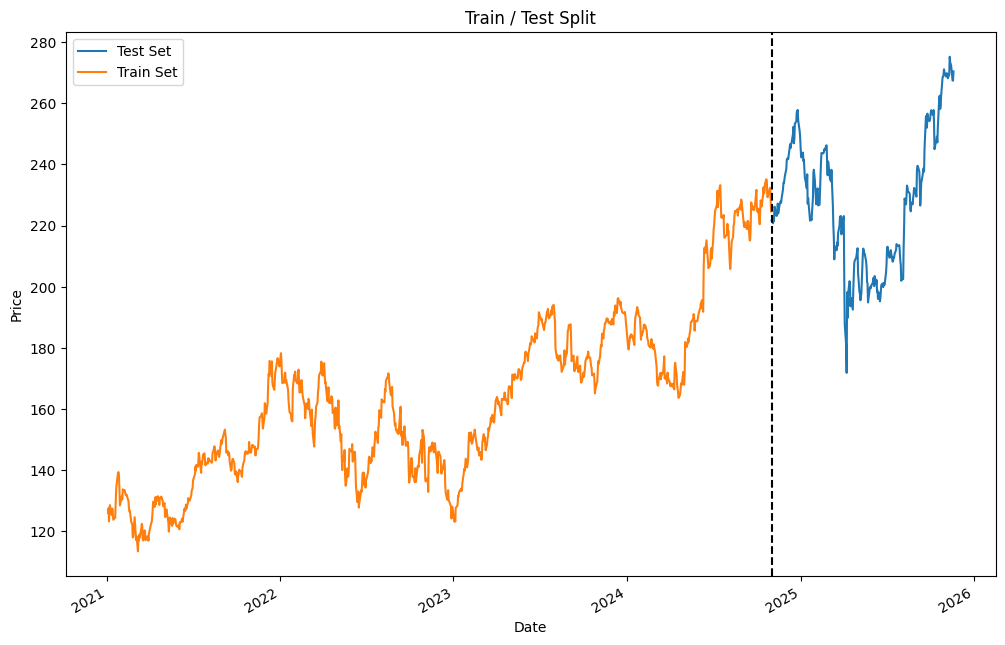

In [23]:
train = df.loc[df.index < '2024-11-01']
test = df.loc[df.index >= '2024-11-01']

fig, axs = plt.subplots(figsize=(12, 8))
test['Close'].plot(ax=axs, xlabel='Date', ylabel='Price', title='Test Set')
train['Close'].plot(ax=axs, xlabel='Date', ylabel='Price', title='Train Set')
axs.legend(['Test Set', 'Train Set'])   
axs.axvline('2024-11-01', color='k', linestyle='--')
plt.title('Train / Test Split')
plt.show()


<Axes: xlabel='Date'>

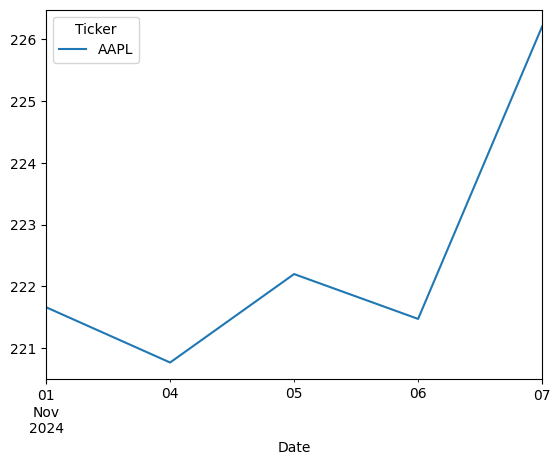

In [25]:
df['Close'].loc[(df.index >= '2024-11-01') & (df.index < '2024-11-08')].plot()

In [ ]:
preds = model.predict(X_test)
plt.plot(y_test.values, label='Real')
plt.plot(preds, label='Predicted')
plt.legend()
plt.show()

In [ ]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)